# 2. Using Backbone Models and Fine Tuning 

In [1]:
# This notebook will cover:
# - Creating a custom classifier on top of a pre-trained backbone
# - Fine-tuning a pre-trained model on Block 1 dataset

### 2.3 Creating a custom Age Category Classification on top of a pre-trained backbone (model Re-Use)

In [1]:
# (a) Import necessary libraries
# ------------------------------------------------------

import numpy as np
import tensorflow as tf                                                 # it contains already all the Keras modules

from sklearn.model_selection import train_test_split                            # for splitting the block 2 dataset into training and validation sets
from sklearn.metrics import confusion_matrix, classification_report             # for evaluation metrics and confusion matrix visualization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout      # for building the classifier model
from tensorflow.keras import Input, Model                                       # for building the classifier model
from tensorflow.keras.optimizers import Adam                                    # for compiling the classifier model

import json                                                             # for saving training history as JSON

from matplotlib import pyplot as plt                                    # for plotting confusion matrix
import seaborn as sns                                                   # for confusion matrix heatmap     
# ------------------------------------------------------

In [2]:
# (b) Load Block 1 images and labels
# ------------------------------------------------------

# Load Block 1 dataset
#   the raw images will be used as inputs for fine-tuning the pre-trained model;
#   the one-hot encoded labels will be used as targets for fine-tuning.
X_block1_input = np.load('X_block1_input.npy')          # raw images, shape: (num_samples in block 1, 128, 128, 3)
y_block1_target = np.load('y_block1_target.npy')        # one-hot labels for age categories

print("Block 1 shapes:", X_block1_input.shape, y_block1_target.shape)

# Load test set for Block 1
X_b1_test = np.load('X_test_norm.npy')                      # raw images for test set
y_b1_test = np.load('y_test_cls_ohe.npy')                   # one-hot labels
# ------------------------------------------------------

Block 1 shapes: (5282, 128, 128, 3) (5282, 6)


In [4]:
# (c) Split Block 1 dataset into training and validation sets
# ------------------------------------------------------

# Convert one-hot encoded labels to integer labels
    # transfom the y_block1_target to 1D array of integer labels for train_test_split function
    # argmax returns the indices of the maximum values along an axis; here axis=1 means along the columns (classes)
y_block1_int = np.argmax(y_block1_target, axis=1)                       # 5 labels (0 to 4) for 5 age categories, shape: (num_samples for Block 1, )
print("Block 1 integer labels shape:", y_block1_int.shape)
print("Block 1 one-hot labels shape:", y_block1_target.shape)

X_b1_train, X_b1_val, y_b1_train, y_b1_val = train_test_split(
    X_block1_input,
    y_block1_target,
    test_size=0.2,                # 20% for validation
    random_state=42,              # for reproducibility
    stratify=y_block1_int         # to maintain class distribution in train and val sets
) 
# ------------------------------------------------------

Block 1 integer labels shape: (5282,)
Block 1 one-hot labels shape: (5282, 6)


In [ ]:
# (d) Load a pre-trained generic CNN backbone
# ------------------------------------------------------

# VGG16 as the pre-trained model (backbone) for fine-tuning; trained on ImageNet, not on this dataset, as it will be fine-tuned later
backbone = tf.keras.applications.VGG16(
    weights='imagenet',                 # load pre-trained weights from ImageNet
    include_top=False,                  # exclude the top classification layers
    input_shape=(128, 128, 3)           # input shape matching our images
)

# Freeze the backbone layers to retain pre-trained features during initial fine-tuning
for layer in backbone.layers:
    layer.trainable = False

# Print backbone summary
backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
# (e) Add a custom classifier on top of the frozen backbone
# --------------------------------------------------------------------

# The backbone (VGG16) has been pre-trained on ImageNet for generic object recognition. 
# We removed the original classification head (include_top=False) because it outputs 1000 classes.
# For our age classification task, we need a new classifier that maps the backbone features to our 6 age categories.
# The custom classifier will learn this mapping while keeping the backbone features frozen initially.

# Since we cannot use Sequential API here (due to the pre-trained model and the removing of the classification head), we will use the Functional API to build the model.
    # Functional API define the input and output layers explicitly, using define each layer calling x = Layer()(x) syntax.

x = backbone.output                             # get the output of the backbone model as input to the classifier
x = GlobalAveragePooling2D()(x)                 # flatten spatial features
x = Dense(128, activation='relu')(x)            # first fully connected layer
x = Dropout(0.3)(x)                             # dropout to reduce overfitting
x = Dense(64, activation='relu')(x)             # second fully connected layer
x = Dropout(0.3)(x)
output = Dense(y_block1_target.shape[1], activation='softmax')(x)   # output layer for age categories

classifier_backbone = Model(inputs=backbone.input, outputs=output)

# Compile the model
classifier_backbone.compile(
    optimizer=Adam(learning_rate=0.0001),        # smaller LR for fine-tuning as the pre-trained weights require smaller updates than training from scratch
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
classifier_backbone.summary()

# Save the model architecture to a JSON file
model_json = classifier_backbone.to_json()
with open("classifier_backbone_model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model architecture as .keras file
classifier_backbone.save('classifier_backbone_model.keras')
# --------------------------------------------------------------------

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [7]:
# (f) Train the backbone classifier and save training history
# --------------------------------------------------------------------

history_backbone = classifier_backbone.fit(
    X_b1_train, 
    y_b1_train,
    validation_data=(X_b1_val, y_b1_val),
    epochs=20,                                      # fewer epochs initially, as pre-trained backbone already has learned features
    batch_size=32
)

# Save training history to a JSON file
with open('backbone_classifier_history.json', 'w') as f:
    json.dump(history_backbone.history, f)
# --------------------------------------------------------------------


Epoch 1/20
133/133 [==============================] - 35s 110ms/step - loss: 1.8299 - accuracy: 0.2840 - val_loss: 1.6083 - val_accuracy: 0.3377
Epoch 2/20
133/133 [==============================] - 13s 100ms/step - loss: 1.6276 - accuracy: 0.3534 - val_loss: 1.5235 - val_accuracy: 0.3652
Epoch 3/20
133/133 [==============================] - 10s 73ms/step - loss: 1.5489 - accuracy: 0.3908 - val_loss: 1.4644 - val_accuracy: 0.4049
Epoch 4/20
133/133 [==============================] - 10s 72ms/step - loss: 1.4731 - accuracy: 0.4151 - val_loss: 1.4158 - val_accuracy: 0.4617
Epoch 5/20
133/133 [==============================] - 10s 75ms/step - loss: 1.4308 - accuracy: 0.4471 - val_loss: 1.3699 - val_accuracy: 0.4863
Epoch 6/20
133/133 [==============================] - 10s 75ms/step - loss: 1.3811 - accuracy: 0.4703 - val_loss: 1.3288 - val_accuracy: 0.4995
Epoch 7/20
133/133 [==============================] - 10s 74ms/step - loss: 1.3290 - accuracy: 0.4845 - val_loss: 1.2859 - val_accurac

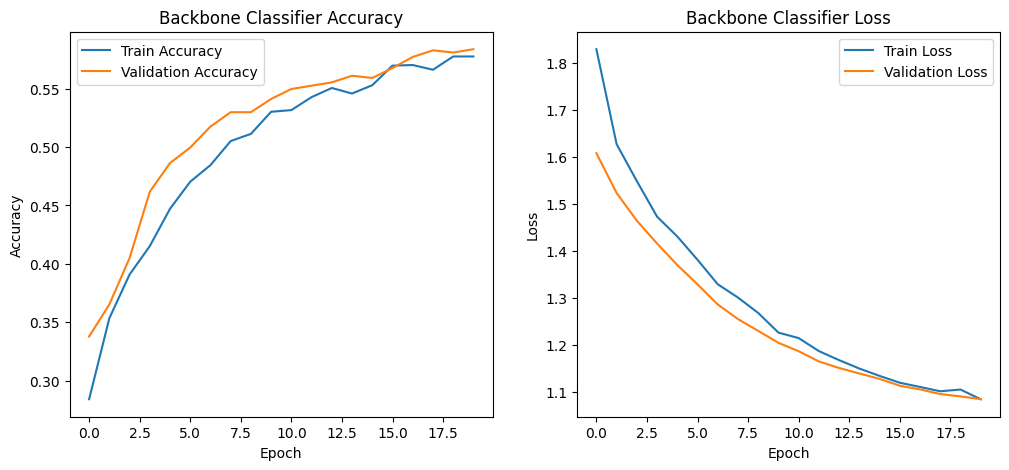

In [8]:
# (g) Plot history of training and validation accuracy and loss
# --------------------------------------------------------------------

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_backbone.history['accuracy'], label='Train Accuracy')
plt.plot(history_backbone.history['val_accuracy'], label='Validation Accuracy')
plt.title('Backbone Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_backbone.history['loss'], label='Train Loss')
plt.plot(history_backbone.history['val_loss'], label='Validation Loss')
plt.title('Backbone Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


31/31 [==============================] - 6s 193ms/step - loss: 1.0694 - accuracy: 0.5637
Test Loss: 1.0694, Test Accuracy: 0.5637
31/31 [==============================] - 3s 91ms/step


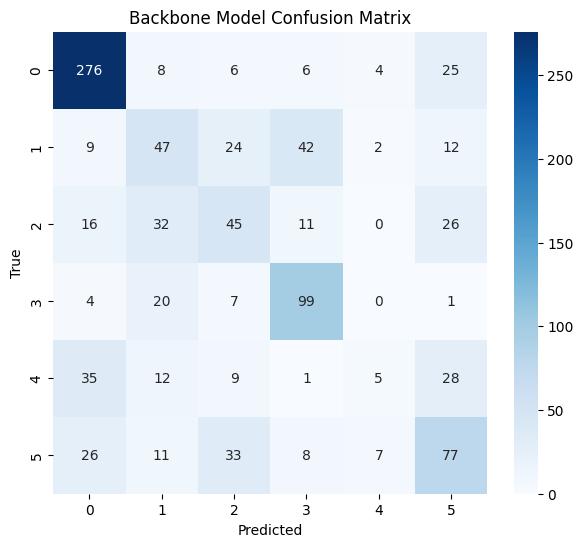

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       325
           1       0.36      0.35      0.35       136
           2       0.36      0.35      0.35       130
           3       0.59      0.76      0.66       131
           4       0.28      0.06      0.09        90
           5       0.46      0.48      0.47       162

    accuracy                           0.56       974
   macro avg       0.47      0.47      0.45       974
weighted avg       0.53      0.56      0.54       974



In [9]:

# (h)Evaluate backbone classifier on test set and create confusion matrix and classification report
# --------------------------------------------------------------------

# Evaluate on Block 1 test set
test_loss, test_acc = classifier_backbone.evaluate(X_b1_test, y_b1_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

y_test_pred = classifier_backbone.predict(X_b1_test)
y_test_true_int = np.argmax(y_b1_test, axis=1)
y_test_pred_int = np.argmax(y_test_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_true_int, y_test_pred_int)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Backbone Model Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test_true_int, y_test_pred_int))
# --------------------------------------------------------------------

In [ ]:
# (i) Summarize of the resuts of the backbone classifier (before fine-tuning)
# --------------------------------------------------------------------

# The VGG16 backbone with a new classifier gives a basic first baseline for age-group prediction. The overall accuracy is moderate and the performance  differs a lot between classes.

# Some age groups (such as Classes 0 and 3) are easier for the model because their images have clearer patterns or a better class balance. Other groups (especially Class 4, and partly 
# Classes 1 and 2) are harder, which may be due to similar facial features across neighbouring ages or fewer training samples.

# This behaviour is typical when training only the classifier head while keeping the convolutional layers frozen. The backbone features are still generic and not yet adapted to 
# the specific structure of our facial age dataset. 

# These results therefore serve as a solid baseline before moving to fine-tuning selected backbone layers, applying class balancing and using data augmentation to improve performance 
# across all age groups.

### 2.4 Fine-tune the entire model (backbone + classifier) on Block 1 dataset

In [11]:
# Fine-tuning the backbone model 
# --------------------------------------------------------------------

# In Part 2.3 we trained only the classifier on top of the frozen VGG16 backbone.
# Now we unfreeze all layers so the whole model can learn from Block 1 images.

# Further fine-tuning of the backbone model is expected to help the model learn more relevant features for age classification, especially for the harder age groups.

# We will fine-tune:
#   - All VGG16 layers (by unfreezing them)
#   - The classifier layers we added (by default they are trainable, so no need to change anything)
# -----> By unfreezing all layers, we allow the entire model to adjust its weights based on the Block 1 dataset (not just the classifier as for the baseline),
# enabling it to learn features more specific to age classification.

# We use a small learning rate to avoid losing the pre-trained knowledge as if higher learning rates are used, the weights may change too much and the model may forget
# the useful features learned from ImageNet.

In [12]:
# (a) Unfreeze all layers in the backbone for fine-tuning
# --------------------------------------------------------------------

for layer in backbone.layers:
    layer.trainable = True
# --------------------------------------------------------------------

In [13]:
# (b) Re-compile the model with a lower learning rate
# --------------------------------------------------------------------

classifier_backbone.compile(
    optimizer=Adam(learning_rate=0.00001),          # even smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)   

# Summary of the model after unfreezing
classifier_backbone.summary()
# --------------------------------------------------------------------

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [17]:
# (c) Fine-tune the entire model; save fine-tuning history  and the fine-tuned model
# --------------------------------------------------------------------

history_finetune = classifier_backbone.fit(
    X_b1_train, y_b1_train,
    validation_data=(X_b1_val, y_b1_val),
    epochs=10,                                  # fewer epochs for fine-tuning as the model is already partially trained and with less epochs is less likely to overfit    
    batch_size=32,
    shuffle=True
)

# Save fine-tuning history to a JSON file
with open('backbone_finetune_history.json', 'w') as f:
    json.dump(history_finetune.history, f)

# Save the entire fine-tuned model
classifier_backbone.save('classifier_backbone_finetuned.keras')
# --------------------------------------------------------------------

Epoch 1/10
133/133 [==============================] - 39s 296ms/step - loss: 0.4490 - accuracy: 0.8220 - val_loss: 0.7906 - val_accuracy: 0.7039
Epoch 2/10
133/133 [==============================] - 37s 277ms/step - loss: 0.4764 - accuracy: 0.8111 - val_loss: 0.9076 - val_accuracy: 0.6802
Epoch 3/10
133/133 [==============================] - 35s 265ms/step - loss: 0.4065 - accuracy: 0.8353 - val_loss: 0.7749 - val_accuracy: 0.7020
Epoch 4/10
133/133 [==============================] - 37s 280ms/step - loss: 0.3598 - accuracy: 0.8549 - val_loss: 0.8378 - val_accuracy: 0.7105
Epoch 5/10
133/133 [==============================] - 37s 278ms/step - loss: 0.3346 - accuracy: 0.8712 - val_loss: 0.8294 - val_accuracy: 0.7209
Epoch 6/10
133/133 [==============================] - 37s 277ms/step - loss: 0.3019 - accuracy: 0.8857 - val_loss: 0.8870 - val_accuracy: 0.6954
Epoch 7/10
133/133 [==============================] - 37s 278ms/step - loss: 0.2903 - accuracy: 0.8914 - val_loss: 0.8598 - val_ac

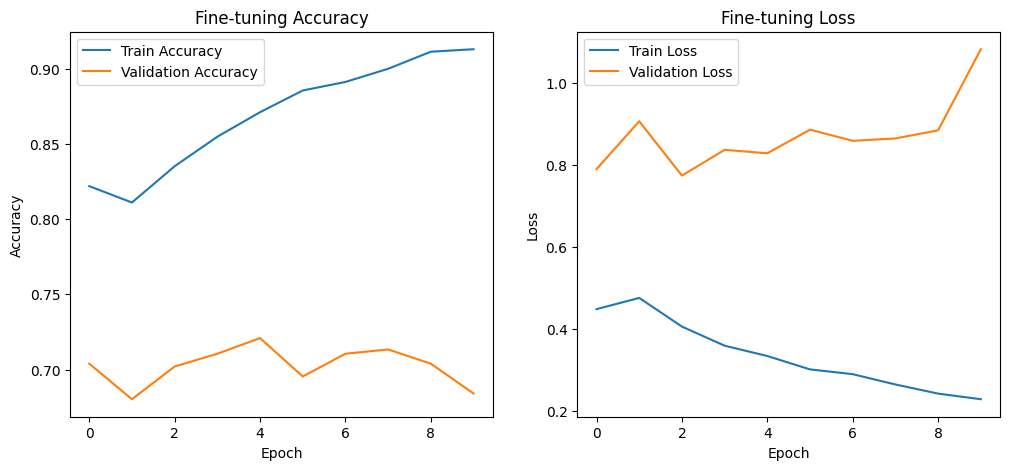

In [18]:
# (d) Plot history of fine-tuning accuracy and loss
# --------------------------------------------------------------------

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
# --------------------------------------------------------------------

31/31 [==============================] - 3s 92ms/step - loss: 1.0135 - accuracy: 0.6848
Fine-tuned Test Loss: 1.0135, Test Accuracy: 0.6848
31/31 [==============================] - 3s 90ms/step


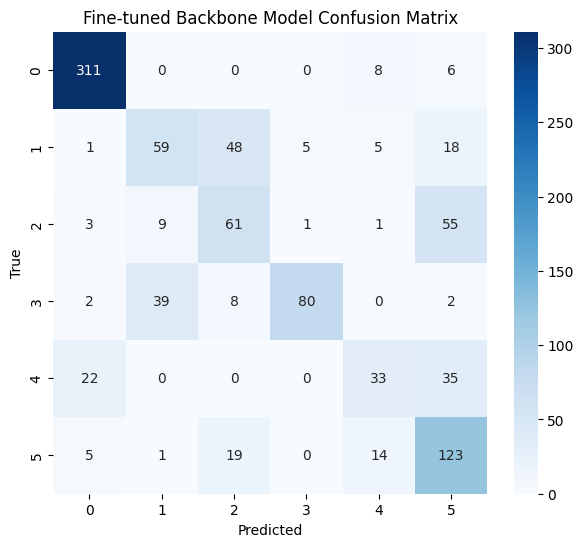

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       325
           1       0.55      0.43      0.48       136
           2       0.45      0.47      0.46       130
           3       0.93      0.61      0.74       131
           4       0.54      0.37      0.44        90
           5       0.51      0.76      0.61       162

    accuracy                           0.68       974
   macro avg       0.65      0.60      0.61       974
weighted avg       0.70      0.68      0.68       974



In [19]:
# (e) Evaluate fine-tuned model on test set and create confusion matrix and classification report
# --------------------------------------------------------------------

# Evaluate on Block 1 test set
test_loss, test_acc = classifier_backbone.evaluate(X_b1_test, y_b1_test)
print(f"Fine-tuned Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

y_test_pred = classifier_backbone.predict(X_b1_test)
y_test_true_int = np.argmax(y_b1_test, axis=1)
y_test_pred_int = np.argmax(y_test_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_true_int, y_test_pred_int)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Fine-tuned Backbone Model Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test_true_int, y_test_pred_int))
# --------------------------------------------------------------------

In [ ]:
# (f) Summarize of the resuts of the fine-tuned backbone classifier
# --------------------------------------------------------------------

# After unfreezing all VGG16 layers and training the whole model with a lower learning rate, the overall accuracy improved from about 0.57 to 0.68. 
# The model now recalls more correctly the previously difficult classes and has better F1-scores for most age groups. 
# Some classes are still harder, but the backbone features have now adapted to the age dataset. 
# Training both the classifier and the backbone together gave better results than training only the classifier head.

# Further fine-tuning, such as unfreezing only selected layers or training longer with very low learning rates, was not performed. 
# ImageNet covers many subjects but not mainly detailed face-age images; the backbone’s features are generic (edges, textures, shapes) - https://en.wikipedia.org/wiki/ImageNet -
# The fine-tuning allowed those generic features to adjust to facial age features, which explains the improved accuracy and better performance on difficult classes.
# However, because the dataset is relatively small and the task (age-group classification) is quite different from ImageNet’s original object-recognition goal, 
# huge gains will be unlikely, without increasing the dataset size with less noisy labels and more diverse images.
# Further fine-tuning might give small improvements but it risks overfitting because the model may memorize specific faces rather than learn general age patterns.
# --------------------------------------------------------------------